In [3]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

In [4]:
import json

wasabi2_events_file = dumplings_directory / "wasabi2_events.json"
wasabi2_txs_file = dumplings_directory / "wasabi2_txs.json"
wasabi_events_file = dumplings_directory / "wasabi_events.json"
wasabi_txs_file = dumplings_directory / "wasabi_txs.json"
whirlpool_events_file = dumplings_directory / "whirlpool_events.json"
whirlpool_txs_file = dumplings_directory / "whirlpool_txs.json"

with open(wasabi2_events_file) as f:
    wasabi2_events = json.load(f)

# with open(wasabi2_txs_file) as f:
#     wasabi2_txs = json.load(f)

# with open(wasabi_events_file) as f:
#     wasabi_events = json.load(f)

# with open(wasabi_txs_file) as f:
#     wasabi_txs = json.load(f)

# with open(whirlpool_events_file) as f:
#     whirlpool_events = json.load(f)

# with open(whirlpool_txs_file) as f:
#     whirlpool_txs = json.load(f)

# Basic analysis
Here are some basic analyses for the coinjoins just to make sure nothign fishy is happening

In [144]:
def find_min_max(tx: blocksci.Tx) -> Tuple[int, int]:
    return (tx.input_count, tx.output_count)

def find_number_of_unique_txs(tx: blocksci.Tx) -> Tuple[int, int]:
    return len(set([x.value for x in tx.inputs])), len(set([x.value for x in tx.outputs]))

In [145]:
unique_counts = chain.map_spliterator(map_func=find_number_of_unique_txs, keys=list(wasabi2_events.keys()), data_directory=str(parser_data_directory), workers=64)

the tasks are planned...


In [149]:
from statistics import median

flattened_unique_inputs = [x[0] for y in unique_counts for x in y]
flattened_unique_outputs = [x[1] for y in unique_counts for x in y]

print("inputs:")
print(f"min: {min(flattened_unique_inputs)}, max: {max(flattened_unique_inputs)}, median: {median(flattened_unique_inputs)}")

print("outputs:")
print(f"min: {min(flattened_unique_outputs)}, max: {max(flattened_unique_outputs)}, median: {median(flattened_unique_outputs)}")

inputs:
min: 1, max: 125, median: 50.0
outputs:
min: 1, max: 75, median: 33.0


In [131]:
minmaxes = chain.map_spliterator(map_func=find_min_max, keys=list(wasabi2_events.keys()), data_directory=str(parser_data_directory), workers=64)

the tasks are planned...


In [134]:
inp, out = minmaxes[0][0]

for x in minmaxes:
    for input1, output1 in x:
        if input1 > inp:
            inp = input1
        if output1 > out:
            out = output1
            
print(inp, out)
        

400 508


# Remix analysis

Here we have the map functions for different remix analyses. The functions should have the following interface
`map_func(tx: blocksci.Tx, **kwargs) -> T`
where `T` is the common result type. The result will be added to the list of results of each worker.

`kwargs` are the arguments passed to each worker.

In [3]:
def find_remixes_within_one_hop(tx: blocksci.Tx, **kwargs):
    """Pass in `events` as kwarg. Will check whether there is an output of `tx` in `events`.
    We can count this as 'remix' transaction.
    """
    cj_events = kwargs['events']
    result = (tx.hash, tx.output_count, [])
    for c, i in enumerate(tx.outputs):
        if not i.is_spent:
            continue
        
        if str(i.spending_tx.hash) in cj_events:
            result[2].append((i.index, True))
            
    return result
        

### Results processing

We take the outputs of the above functions and compute various statistics.

In [ ]:
wasabi2_results = chain.map_spliterator(map_func=find_remixes_within_one_hop, keys=list(wasabi2_txs["coinjoins"].keys()), data_directory=str(parser_data_directory), workers=64, events=wasabi2_events.keys())
wasabi_results = chain.map_spliterator(map_func=find_remixes_within_one_hop, keys=list(wasabi_txs["coinjoins"].keys()), data_directory=str(parser_data_directory), workers=64, events=wasabi_events.keys())
whirlpool_results = chain.map_spliterator(map_func=find_remixes_within_one_hop, keys=list(whirlpool_txs["coinjoins"].keys()), data_directory=str(parser_data_directory), workers=128, events=whirlpool_events.keys())

In [4]:
%time wasabi_results = chain.map_spliterator(map_func=find_remixes_within_one_hop, keys=list(wasabi_events.keys()), data_directory=str(parser_data_directory), workers=64, events=wasabi_events.keys())

the tasks are planned...
CPU times: user 10.4 s, sys: 45.3 s, total: 55.7 s
Wall time: 1min 1s


In [19]:
%time whirlpool_results = chain.map_spliterator(map_func=find_remixes_within_one_hop, keys=list(whirlpool_events.keys()), data_directory=str(parser_data_directory), workers=64, events=whirlpool_events.keys())

the tasks are planned...
CPU times: user 3min 41s, sys: 2min 19s, total: 6min
Wall time: 6min 19s


In [14]:
%time wasabi2_results = chain.map_spliterator(find_remixes_within_one_hop, list(wasabi2_events.keys()), str(parser_data_directory), workers=64, events=wasabi2_events.keys())

the tasks are planned...
CPU times: user 12.9 s, sys: 1min 50s, total: 2min 3s
Wall time: 2min 17s


In [20]:
def compute_remix_stats(results, events, key):
    stats_computed = {"remix": 0, "left": 0}
    
    for one in results:
        for txid, all_outputs, actual in one:
            stats_computed["remix"] += len(actual)
            stats_computed["left"] += all_outputs - len(actual)
    
    print(key)
    print(stats_computed)

    dumplings_stats = {"dumplings_remix": 0}

    for tx in events.values():
        for out in tx["outputs"].values():
            if out["mix_event_type"] == "MIX_REMIX":
                dumplings_stats["dumplings_remix"] += 1

    print(dumplings_stats)
    print(f"dumplings - computed: {dumplings_stats['dumplings_remix'] - stats_computed['remix']}\n")

compute_remix_stats(wasabi2_results, wasabi2_txs["coinjoins"], "wasabi2 1 hop")
compute_remix_stats(wasabi_results, wasabi_txs["coinjoins"], "wasabi 1 hop")
compute_remix_stats(whirlpool_results, whirlpool_txs["coinjoins"], "whirlpool 1 hop")

wasabi2 1 hop
{'remix': 6283513, 'left': 955987}
{'dumplings_remix': 6293405}
dumplings - computed: 9892

wasabi 1 hop
{'remix': 2111051, 'left': 1863723}
{'dumplings_remix': 2111054}
dumplings - computed: 3

whirlpool 1 hop
{'remix': 1694653, 'left': 1098533}
{'dumplings_remix': 1656451}
dumplings - computed: -38202



# Consolidation analysis

The functions for consolidation analysis are here. The interface is still the same:
`map_func(tx: blocksci.Tx, **kwargs) -> list[T]`

In [9]:
from typing import List, Dict, Tuple

def find_outputs_one_hop(tx: blocksci.Tx, found: Dict[str, List[str]]):
    for output in tx.outputs:
        if not output.is_spent:
            continue

        output_spent_in = str(output.spending_tx.hash)
        if output_spent_in not in found:
            found[output_spent_in] = 0
        found[output_spent_in] += 1



def find_consolidation(tx: blocksci.Tx, **kwargs) -> List[Tuple[str, Dict[str, List[str]]]]:
    found_for_tx = {}
    find_outputs_one_hop(tx, found_for_tx)
    return str(tx.hash), found_for_tx


def has_tx_output_in_coinjoin_events(tx: blocksci.Tx, **kwargs) -> bool:
    cj_events = kwargs["events"]
    for output in tx.outputs:
        if not output.is_spent:
            continue

        if str(output.spending_tx.hash) in cj_events:
            return True

    return False


def find_outputs_two_hops(tx: blocksci.Tx, found: Dict[str, List[str]]):
    for output in tx.outputs:
        if not output.is_spent:
            continue

        if output.spending_tx.output_count < 2:
            output_spent_in = str(output.spending_tx.hash)
            if output_spent_in not in found:
                found[output_spent_in] = 0
            found[output_spent_in] += 1
            continue

        for output2 in output.spending_tx.outputs:
            if not output2.is_spent:
                continue
                
            if output2.spending_tx.output_count < 2:
                output_spent_in = str(output2.spending_tx.hash)
                if output_spent_in not in found:
                    found[output_spent_in] = 0
                found[output_spent_in] += 1
                continue


def find_outputs_three_hops(tx: blocksci.Tx, found: Dict[str, List[str]]):
    for output in tx.outputs:
        if not output.is_spent:
            continue
            
        found_match = False

        if output.spending_tx.output_count < 2:
            output_spent_in = str(output.spending_tx.hash)
            if output_spent_in not in found:
                found[output_spent_in] = 0
            found[output_spent_in] += 1
            continue

        for output2 in output.spending_tx.outputs:
            if found_match:
                break
            if not output2.is_spent:
                continue
                
            if output2.spending_tx.output_count < 2:
                output_spent_in = str(output2.spending_tx.hash)
                if output_spent_in not in found:
                    found[output_spent_in] = 0
                found[output_spent_in] += 1
                found_match = True
                break
            
            for output3 in output2.spending_tx.outputs:
                if not output3.is_spent:
                    continue

                if output3.spending_tx.output_count < 2:
                    output_spent_in = str(output3.spending_tx.hash)
                    if output_spent_in not in found:
                        found[output_spent_in] = 0
                    found[output_spent_in] += 1
                    found_match = True
                    break
                    
def find_consolidation_three_hops(tx: blocksci.Tx):
    found_for_tx = {}
    find_outputs_three_hops(tx, found_for_tx)
    return (str(tx.hash), found_for_tx)


def find_consolidation_two_hops(tx: blocksci.Tx):
    found_for_tx = {}
    find_outputs_two_hops(tx, found_for_tx)
    return (str(tx.hash), found_for_tx)





In [10]:
%time wasabi2_consolidation_three_hop = chain.map_spliterator(map_func=find_consolidation_three_hops, keys=list(wasabi2_events.keys()), data_directory=str(parser_data_directory), workers=64)
# %time wasabi_consolidation_three_hop = chain.map_spliterator(map_func=find_consolidation_three_hops, keys=list(wasabi_events.keys()), data_directory=str(parser_data_directory), workers=64)


the tasks are planned...
CPU times: user 8.07 s, sys: 49.5 s, total: 57.6 s
Wall time: 1min 30s


In [11]:
%time wasabi_consolidation_three_hop = chain.map_spliterator(map_func=find_consolidation_three_hops, keys=list(wasabi_events.keys()), data_directory=str(parser_data_directory), workers=64)

the tasks are planned...
CPU times: user 8.15 s, sys: 50.6 s, total: 58.8 s
Wall time: 1min 11s


In [37]:
%time wasabi2_consolidation = chain.map_spliterator(map_func=find_consolidation, keys=list(wasabi2_events.keys()), data_directory=str(parser_data_directory), workers=64)


the tasks are planned...
CPU times: user 9.61 s, sys: 1min 20s, total: 1min 29s
Wall time: 1min 37s


In [38]:
%time wasabi_consolidation = chain.map_spliterator(map_func=find_consolidation, keys=list(wasabi_events.keys()), data_directory=str(parser_data_directory), workers=64)


the tasks are planned...
CPU times: user 10.3 s, sys: 1min 22s, total: 1min 32s
Wall time: 1min 39s


In [39]:
%time whirlpool_consolidation = chain.map_spliterator(map_func=find_consolidation, keys=list(whirlpool_events.keys()), data_directory=str(parser_data_directory), workers=128)


the tasks are planned...
CPU times: user 4min 22s, sys: 3min 11s, total: 7min 34s
Wall time: 8min


In [40]:
%time wasabi2_consolidation_two_hop = chain.map_spliterator(map_func=find_consolidation_two_hops, keys=list(wasabi2_events.keys()), data_directory=str(parser_data_directory), workers=64)

the tasks are planned...
CPU times: user 8.89 s, sys: 1min 29s, total: 1min 38s
Wall time: 1min 48s


In [41]:
%time wasabi_consolidation_two_hop = chain.map_spliterator(map_func=find_consolidation_two_hops, keys=list(wasabi_events.keys()), data_directory=str(parser_data_directory), workers=64)

the tasks are planned...
CPU times: user 11.1 s, sys: 1min 31s, total: 1min 42s
Wall time: 1min 53s


In [42]:
%time whirlpool_consolidation_two_hop = chain.map_spliterator(map_func=find_consolidation_two_hops, keys=list(whirlpool_events.keys()), data_directory=str(parser_data_directory), workers=128)


the tasks are planned...
CPU times: user 4min 26s, sys: 3min 26s, total: 7min 53s
Wall time: 8min 17s


### Consolidation analyses

Following are the functions computing the actual result analyses.

31034
w2 unpaired: 0
w unpaired: 0


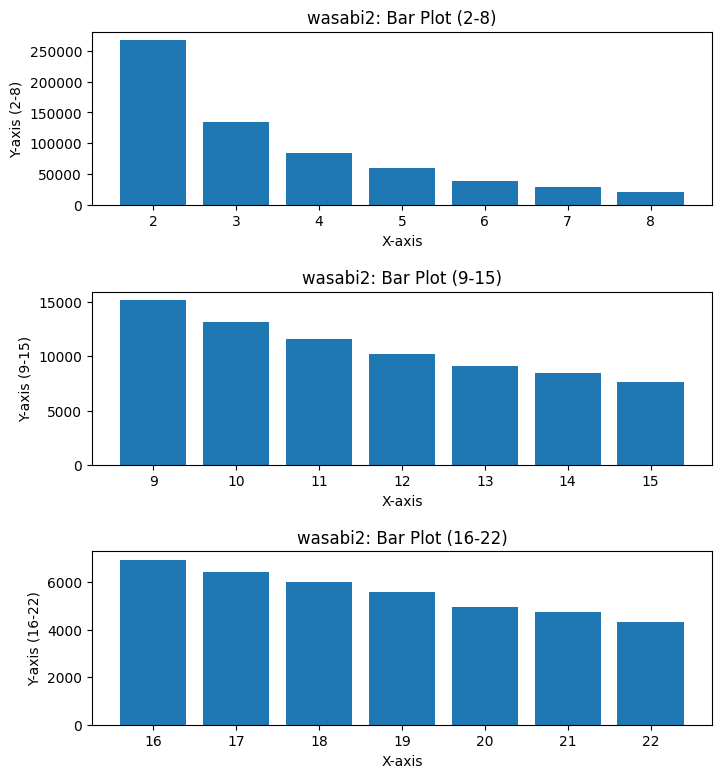

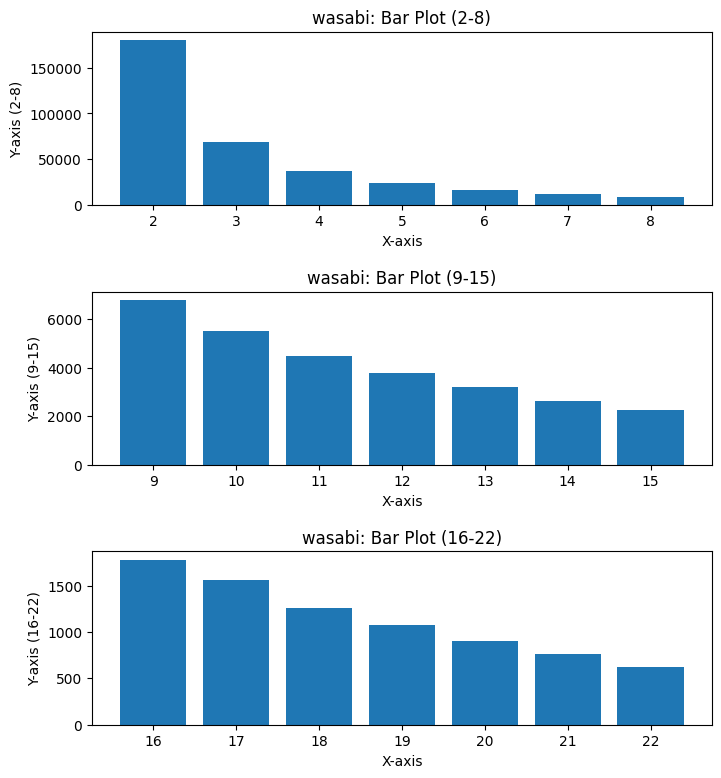

In [25]:
from collections import defaultdict


def compute_consolidated_txes_in_one_hop(consolidated):
    total_outgoing = 0
    counts_of_consolidated_txes_in_one_hop = defaultdict(int)
    for root_tx, dct in consolidated:
            for outbound_tx, count in dct.items():
                if outbound_tx in wasabi2_events or outbound_tx in wasabi_events or outbound_tx in whirlpool_events:
                    continue

                counts_of_consolidated_txes_in_one_hop[count] += 1
    return counts_of_consolidated_txes_in_one_hop


# w2_consolidation_1hop = compute_consolidated_txes_in_one_hop(wasabi2_consolidation)
# w_consolidation_1hop = compute_consolidated_txes_in_one_hop(wasabi_consolidation)
# whirl_consolidation_1hop = compute_consolidated_txes_in_one_hop(whirlpool_consolidation)

def plot_barplot_from_dictionary(dct):
    plt.bar(range(len(dct)), list(dct.values()), align='center')
    plt.xticks(range(len(dct)), list(dct.keys()))
    plt.show()



def make_graph(data, name):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8, 9))

    # Plot the data for 2-8 on the first subplot
    ax1.bar(list(range(2, 9)), [data[key] for key in range(2, 9)])
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis (2-8)')
    ax1.set_title(f'{name}: Bar Plot (2-8)')

    # Plot the data for 9-15 on the second subplot
    ax2.bar(list(range(9, 16)), [data[key] for key in range(9, 16)])
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis (9-15)')
    ax2.set_title(f'{name}: Bar Plot (9-15)')

    ax3.bar(list(range(16, 23)), [data[key] for key in range(16, 23)])
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis (16-22)')
    ax3.set_title(f'{name}: Bar Plot (16-22)')

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    # Display the plot
    plt.show()

# print(f"w2 unpaired: {w2_consolidation_1hop[1]}")
# print(f"w unpaired: {w_consolidation_1hop[1]}")
# print(f"whirlpool unpaired: {whirl_consolidation_1hop[1]}")

# make_graph(w2_consolidation_1hop, "wasabi2")
# make_graph(w_consolidation_1hop, "wasabi")
# make_graph(whirl_consolidation_1hop, "whirlpool")



# w2_2hop_consolidated = compute_consolidated_txes_in_one_hop(wasabi2_consolidation_two_hop)
# w_2hop_consolidated = compute_consolidated_txes_in_one_hop(wasabi_consolidation_two_hop)
# wh_2hop_consolidated = compute_consolidated_txes_in_one_hop(whirlpool_consolidation_two_hop)


# make_graph(w2_2hop_consolidated, "two hop consolidation to one output wasabi2")
# make_graph(w_2hop_consolidated, "two hop consolidation to one output wasabi")
# make_graph(wh_2hop_consolidated, "two hop consolidation to one output whirlpool")

print(len(res_w2))
w2_consolidation_3hop = compute_consolidated_txes_in_one_hop(res_w2)
w_consolidation_3hop = compute_consolidated_txes_in_one_hop(res_w1)


print(f"w2 unpaired: {w2_consolidation_3hop[1]}")
print(f"w unpaired: {w_consolidation_3hop[1]}")


make_graph(w2_consolidation_3hop, "wasabi2")
make_graph(w_consolidation_3hop, "wasabi")

In [ ]:
in_tx = '0002eb55bd780c4fc10f212bb686a0a9426ef11d611827605ba8f82db30bcbbc'
consolidated_tx = '0abebd6704fcd886b1e74815ce05a24a11aa2d0e543729d6dbd18629c72874a7'

in_tx = chain.tx_with_hash(in_tx)
consolidated_tx = chain.tx_with_hash(consolidated_tx) 

print(consolidated_tx.output_count)


from typing import Optional, Set

consolidated_txs_lost = list(find_consolidation_two_hops(in_tx))[1]

# print(consolidated_txs)
consolidated_txs = [x for x, y in consolidated_txs_lost.items() if y < 10]
print(len(consolidated_txs), consolidated_txs_lost[consolidated_txs[0]])

def subset_sum_rec(nums: List[int], total: int, start: int, memo: Dict[Tuple[int, int], Optional[Set[int]]]) -> Optional[Set[int]]:
    if total == 0:
        return set()

    if start == len(nums):
        return None

    key = (start, total)
    if key in memo:
        return memo[key]

    num = nums[start]
    if num.value > total:
        memo[key] = None
        return None

    result = subset_sum_rec(nums, total - num.value, start + 1, memo)
    if result is not None:
        result.add(num)
        memo[key] = result
        return result

    result = subset_sum_rec(nums, total, start + 1, memo)
    memo[key] = result
    return result

def find_sum_candidates(tx, inputs, output_value):
    memo = {}
    sorted_inputs = sorted(filter(lambda y: y.value <= output_value, inputs), key=lambda x: x.value)
    return subset_sum_rec(sorted_inputs, output_value, 0, memo)

a = set()
for i in range(3):
    inputs = set(in_tx.inputs) - a
    value = chain.tx_with_hash(consolidated_txs[i]).outputs[0].value
    r = find_sum_candidates(in_tx, inputs, value)
    if r:
        r = a

print(a)


In [25]:
import datetime
in_tx = '0002eb55bd780c4fc10f212bb686a0a9426ef11d611827605ba8f82db30bcbbc'

In [16]:
in_tx = '0002eb55bd780c4fc10f212bb686a0a9426ef11d611827605ba8f82db30bcbbc'
consolidated_tx = '0abebd6704fcd886b1e74815ce05a24a11aa2d0e543729d6dbd18629c72874a7'

in_tx = chain.tx_with_hash(in_tx)
consolidated_tx = chain.tx_with_hash(consolidated_tx) 

print(in_tx)
print(consolidated_tx.inputs[0])
print(consolidated_tx.inputs[0].spent_output.address_type)

Tx(len(txins)=196, len(txouts)=171, size_bytes=18749, block_height=796000, tx_index=856691436)
TxIn(spent_tx_index=857483522, address=WitnessPubkeyAddress(bc1qszn4m06qd42ndvtd0tl6ncf36405zr5xacrhjx), value=5000)
Pay to witness pubkey hash


# embrace VUT

Let's try to use some analyses with [coinomon](https://coinomon.bazar.nesad.fit.vutbr.cz/#/Authentication/login).

- get all coinjoins in one month (say Feb 23)
- get all output txs from them (with one output)
- pick one randomly and get some data about them from coinomon
- ???
- profit

In [3]:
import requests
from typing import Dict, Any

class CoinomonClient:
    def __init__(self, token: str) -> None:
        self.crypto = "BTC"
        self.headers = {"Authorization": f"Bearer {token}"}
        self.base_url = "https://coinomon.bazar.nesad.fit.vutbr.cz/"
    
    def get_address_info(self, address: str) -> Dict[str, Any]:
        response = requests.get(f"{self.base_url}jwt/v1/{self.crypto}/cryptoaddress/{address}/summary", headers=self.headers)
        if response.status_code >= 400:
            print(str(response.text))
            return {}
        
        return response.json()
    
    
    def get_cluster_info(self, cluster_id: str) -> Dict[str, Any]:
        response = requests.get(f"/jwt/v1/{self.crypto}/cryptocluster/{cluster_id}", headers=self.headers)
        if response.status_code >= 400:
            print(str(response))
            return {}
        
        return response.json()
    
    def get_cluster_addresses(self, cluster_id: str) -> Dict[str, Any]:
        response = requests.get(f"/jwt/v1/{self.crypto}/cryptocluster/{cluster_id}/addresses", headers=self.headers)
        if response.status_code >= 400:
            print(str(response))
            return {}
        
        return response.json()
    
token = "insert here"

coinomon_client = CoinomonClient(token)

In [10]:
# help(chain.filter_in_keys)
%time txes = chain.filter_in_keys(wasabi2_events, 0, len(chain))

Size of keys: 31089
CPU times: user 7min 21s, sys: 0 ns, total: 7min 21s
Wall time: 8.82 s


31034

In [5]:


# start, end = get_block_height_range('2023-02-01', '2023-02-28')
# %time res = chain.find_consolidation_3_hops(wasabi2_events, start, end)
%time res_w1 = chain.find_consolidation_3_hops(wasabi_events, 0, len(chain))
# %time res_w2 = chain.find_consolidation_3_hops(wasabi2_events, 0, len(chain))
# %time res_wh = chain.find_consolidation_3_hops(whirlpool_events, 0, len(chain))

# %time res = chain.find_consolidation_3_hops(whirlpool_events, 774513, 778584)

CPU times: user 7min 44s, sys: 24.6 s, total: 8min 9s
Wall time: 5.61 s


In [ ]:
import json

max_outputs = "", "", 0
            
for tx, outputs in res:
    for out, val in outputs.items():
        if val > max_outputs[2]:
            max_outputs = out, tx, val

print(len(res))
print(max_outputs)
tx = chain.tx_with_hash(max_outputs[0])
coinomon_data = coinomon_client.get_address_info(tx.outputs[0].address.address_string)
coinomon_data["data"].pop("firstTx")
coinomon_data["data"].pop("lastTx")
print(json.dumps(coinomon_data, indent=4))

tx_start = chain.tx_with_hash(max_outputs[1])

coinomon_data = coinomon_client.get_address_info(tx_start.outputs[0].address.address_string)
coinomon_data["data"].pop("firstTx")
coinomon_data["data"].pop("lastTx")
print(json.dumps(coinomon_data, indent=4))




In [ ]:
for tx, _ in res:
    tx = chain.tx_with_hash(tx)
    coinomon_data = coinomon_client.get_address_info(tx.outputs[0].address.address_string)
    if coinomon_data["data"]["alarms"]:
        print(coinomon_data)
        break

# Juralysis

Try some BlockSci clustering on some coinjoin output.
Let's pick the same way as before - Feb2023, one with largest tx count (why not).

In [4]:
%time jura_res = chain.find_consolidation_3_hops(wasabi_events, start, end)

NameError: name 'end' is not defined

In [50]:
legacy_heuristic = blocksci.heuristics.change.legacy

cm = blocksci.cluster.ClusterManager.create_clustering("/mnt/anal/cluster", chain, heuristic=legacy_heuristic)

99.93% done


In [62]:
jura_tx = chain.tx_with_hash(list(jura_res[0][1].keys())[0]) # don't ask
cluster = cm.cluster_with_address(jura_tx.outputs[0].address)
print(cluster.address_count())

600232178


In [66]:
cnt = 0
for i in cm.clusters().to_list():
    cnt += 1
    
print(cnt)

781217556


In [ ]:
outputs = chain.tx_with_hash(res_w2[-3][0]).outputs
m_o = map(lambda x: x.value, outputs)
print(list(sorted(m_o, reverse=True)))

In [68]:
from collections import defaultdict
outputs = {}

for k in wasabi2_events:
    try:
        tx = chain.tx_with_hash(k)
    except Exception:
#         print(k, "not found")
        pass
    for out in tx.outputs:
        value = out.value
        if value not in outputs:
            outputs[value] = 0
        outputs[value] += 1
    
# import json
# print(json.dumps(outputs, indent=4))

In [73]:
f = list(sorted(outputs.items(), key=lambda x: -x[1]))
a = {k: v for k, v in f}
# print(json.dumps(a, indent=4))
print(len(list(filter(lambda x: x[1] > 10, a.items()))))

997


In [ ]:
common = [5000, 6561, 8192, 10000, 13122, 16384, 19683, 20000, 32768, 39366, 50000, 59049, 65536, 100000, 118098, 131072,
 177147, 200000, 262144, 354294, 500000, 524288, 531441, 1000000, 1048576, 1062882, 1594323, 2000000, 2097152,
3188646, 4194304, 4782969, 5000000, 8388608, 9565938, 10000000, 14348907, 16777216, 20000000, 28697814, 33554432,
43046721, 50000000, 67108864, 86093442, 100000000, 129140163, 134217728, 200000000, 258280326, 268435456, 387420489,
500000000, 536870912, 774840978, 1000000000, 1073741824, 1162261467, 2000000000, 2147483648, 2324522934, 3486784401,
4294967296, 5000000000, 6973568802, 8589934592, 10000000000, 10460353203, 17179869184, 20000000000, 20920706406,
31381059609, 34359738368, 50000000000, 62762119218, 68719476736, 94143178827, 100000000000, 137438953472]


for i in common:
    print(f"{i}: {a.get(i)}")
# print(a[10000000000])

# Analysis over the coinjoins (friends do not pay)
**(petrs request)**

- export all transactions `X`:
    - X is 2 hops away from a ww2 coinjoin
    - all inputs to X are from a WW2 coinjoin
- output the same as `wasabi2_events.json`
Structure:
- txid
    - txid
    - block_index
    - broadcast_time
    - inputs
        - input number
            - value
            - wallet_name
            - mix_event_type
    - outputs
        - output number
            - value
            - wallet_name
            - mix_event_type
    - num_inputs
    - num_outputs
    
# !!!!!!! OUTPUT IS SPENT IN SPENDING TX !!!!!!!
# !!!!!!! INPUT WAS SPENT IN SPENT TX !!!!!!!

In [20]:
key = next(iter(wasabi2_events.keys()))
key_tx = chain.tx_with_hash(key)
first_next = key_tx.outputs[0].spending_tx
print(key_tx.hash)
print(first_next.hash)
print(first_next.outputs[0].spending_tx.hash)
print(first_next.outputs[0].spending_tx.inputs[0].spent_tx.hash)
print(next(iter(wasabi2_events.values()))["inputs"])

0002eb55bd780c4fc10f212bb686a0a9426ef11d611827605ba8f82db30bcbbc
1e2a7e9ec3291cf0a6067b3ceb7b2e3e245cc2fc0fb69068b932baad36f22381
f6eb03b73c66ce37d0a58013093a3e9d7cd4716f8af9c72ae59c0e1f02b69693
1e2a7e9ec3291cf0a6067b3ceb7b2e3e245cc2fc0fb69068b932baad36f22381
{'63': {'value': 9653620, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '64': {'value': 9598093, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '65': {'value': 9597044, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '66': {'value': 9518520, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '80': {'value': 3910526, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}}


In [ ]:
from typing import Dict, List


# outputs list of transactions where the condition holds
def find_friends_do_not_pay_txes(tx: blocksci.Tx, **kwargs) -> List[str]:
    ww2_events = kwargs["ww2_events"]
    result = []
    for out1 in tx.outputs:
        if not out1.is_spent:
            continue
        
        for out2 in out1.spending_tx.outputs:
            if not out2.is_spent:
                continue
            
            if not out2.spending_tx.hash in ww2_events:
                continue
            
            curr = out2.spending_tx
            for inp in curr.inputs:
                if str(inp.spent_tx.hash) not in ww2_events:
                    break
            else:
                result.append(str(curr.hash))
            
            
            

%time friends = chain.map_spliterator(map_func=find_friends_do_not_pay_txes, keys=list(wasabi2_events.keys()), data_directory=str(parser_data_directory),ww2_events=wasabi2_events,workers=64)

In [13]:
start, stop = get_block_height_range('2023-01-01', '2023-02-01')
%time friends = chain.find_friends_who_dont_pay(keys=wasabi2_events, start=0, stop=len(chain))

CPU times: user 7min 13s, sys: 57.9 s, total: 8min 11s
Wall time: 8.53 s


In [41]:
from typing import Dict, Any, List

def process_inputs(tx: blocksci.Tx) -> List[Dict[str, Any]]:
    res = []
    inp: blocksci.Input
    for inp in tx.inputs:
        spent_tx: blocksci.Tx = inp.spent_tx
        imm = {
            str(inp.index): {
                "value": inp.value,
                "wallet_name": inp.address,
                "is_ww2_coinjoin": str(inp.spent_tx.hash) in wasabi2_events
            }
        }
        res.append(imm)
        
    return res

counter = 0

def process_outputs(tx: blocksci.Tx) -> List[Dict[str, Any]]:
    res = []
    out: blocksci.Output
    for out in tx.outputs:
        imm = {
            str(out.index): {
                "value": out.value,
                "wallet_name": out.address,
                "is_ww2_coinjoin": out.is_spent and str(out.spending_tx.hash) in wasabi2_events
            }
        }
        res.append(imm)
        
    return res


def fill_json_info(tx: blocksci.Tx) -> Dict[str, Any]:
    return {
        "txid": str(tx.hash),
        "block_index": str(tx.block_height),
        "broadcast_time": tx.block_time,
        "num_inputs": tx.input_count,
        "num_outputs": tx.output_count,
        "inputs": process_inputs(tx),
        "outputs": process_outputs(tx),
    }

result = {}

for tx_id in friends:
    tx = chain.tx_with_hash(tx_id)
    result[tx_id] = fill_json_info(tx)
    
print(len(result))


87259


In [42]:
import json

with open('/mnt/anal/ww2_fdnp.json', 'w') as f:
    json.dump(result, f, indent=4, default=str)

In [ ]:
with open('/mnt/anal/ww2_fdnp.json', 'r') as f:
    res = json.load(f)
    
for tx, val in res.items():
    for s in val["inputs"]:
        for inp, vals in s.items():
            if vals['is_ww2_coinjoin']:
                print(tx, inp, vals)
                break
                
                
# tx = friends[0]
# tx = chain.tx_with_hash(tx)

# print(str(tx.inputs[0].spent_tx.hash) in wasabi2_events)